In [10]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support
from torchvision import datasets, transforms

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [3]:
# Load dataset
train_dataset = datasets.ImageFolder(root="/kaggle/input/ewaste/modified-dataset/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/kaggle/input/ewaste/modified-dataset/val", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/ewaste/modified-dataset/test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
# Get number of classes
num_classes = len(train_dataset.classes)
print(num_classes)
class_names = train_dataset.classes
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [6]:
# Load ViT model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model = model.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [7]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    

In [8]:
# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    return correct / total

In [24]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.0020, Train Acc: 0.9996, Val Acc: 0.9733
Epoch 2/10, Loss: 0.0156, Train Acc: 0.9954, Val Acc: 0.9867
Epoch 3/10, Loss: 0.0014, Train Acc: 1.0000, Val Acc: 0.9833
Epoch 4/10, Loss: 0.0002, Train Acc: 1.0000, Val Acc: 0.9833
Epoch 5/10, Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.9833
Epoch 6/10, Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.9833
Epoch 7/10, Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.9833
Epoch 8/10, Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.9833
Epoch 9/10, Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.9833
Epoch 10/10, Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.9833


In [25]:
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9900


In [10]:
# Prediction function
def predict(model, data_loader):
    model.eval()
    predictions = []
    probabilities = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            predictions.extend(predicted.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    
    return predictions, probabilities

In [27]:
# Get predictions on test set
test_preds, test_probs = predict(model, test_loader)
print("Test Predictions:", test_preds)

Test Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [23]:
def evaluate_model_test(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, predicted = torch.max(probs, 1)  # Get class indices
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(probs.cpu().numpy())  # Store probability distributions
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, np.argmax(all_preds, axis=1))  # Convert probs to class indices
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, np.argmax(all_preds, axis=1), target_names=class_names))

    # AUC-ROC Curve
    if num_classes > 1:
        roc_score = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        print(f"AUC-ROC Score: {roc_score:.4f}")

        # Plot ROC curve
        plt.figure(figsize=(4, 3))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_preds)[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_names[i]}')
        
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("AUC-ROC Curve")
        plt.legend()
        plt.show()

    return correct / total

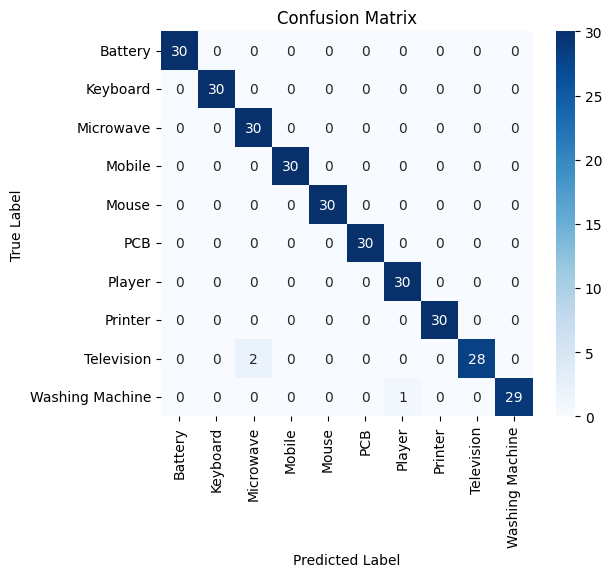

Classification Report:
                 precision    recall  f1-score   support

        Battery       1.00      1.00      1.00        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.94      1.00      0.97        30
         Mobile       1.00      1.00      1.00        30
          Mouse       1.00      1.00      1.00        30
            PCB       1.00      1.00      1.00        30
         Player       0.97      1.00      0.98        30
        Printer       1.00      1.00      1.00        30
     Television       1.00      0.93      0.97        30
Washing Machine       1.00      0.97      0.98        30

       accuracy                           0.99       300
      macro avg       0.99      0.99      0.99       300
   weighted avg       0.99      0.99      0.99       300

AUC-ROC Score: 0.9999


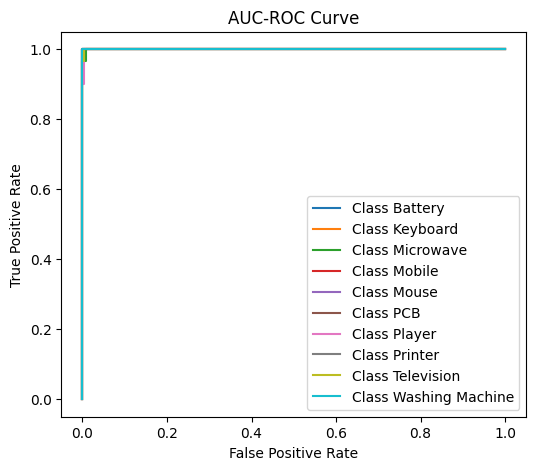

Test Accuracy: 0.9900


In [45]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

In [48]:
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9905, Recall: 0.9900, F1-score: 0.9900
Test Accuracy: 0.9900


In [49]:
torch.save(model.state_dict(), "vit_e_waste_classification.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)
# model.load_state_dict(torch.load("vit_e_waste_classification.pth"))
# model = model.to(device)
# model.eval()  # Set model to evaluation mode
# print("Model loaded successfully!")


## VGG 16

In [5]:
import torchvision.models as models

# Load VGG16 model
# model = models.vgg16(pretrained=True)
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modify classifier for the new number of classes
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=5e-4)  #2e-5 se 5e-5

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]  


In [13]:
# Train the model                
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

Precision: 0.9164, Recall: 0.9100, F1-score: 0.9105
Epoch 1/3, Loss: 1.0787, Train Acc: 0.6567, Val Acc: 0.9100
Precision: 0.9264, Recall: 0.9200, F1-score: 0.9199
Epoch 2/3, Loss: 0.2445, Train Acc: 0.9242, Val Acc: 0.9200
Precision: 0.9519, Recall: 0.9500, F1-score: 0.9500
Epoch 3/3, Loss: 0.0970, Train Acc: 0.9692, Val Acc: 0.9500


In [16]:
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9626, Recall: 0.9600, F1-score: 0.9603
Test Accuracy: 0.9600


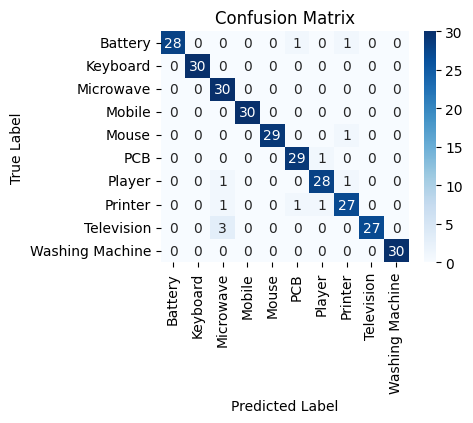

Classification Report:
                 precision    recall  f1-score   support

        Battery       1.00      0.93      0.97        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.86      1.00      0.92        30
         Mobile       1.00      1.00      1.00        30
          Mouse       1.00      0.97      0.98        30
            PCB       0.94      0.97      0.95        30
         Player       0.93      0.93      0.93        30
        Printer       0.90      0.90      0.90        30
     Television       1.00      0.90      0.95        30
Washing Machine       1.00      1.00      1.00        30

       accuracy                           0.96       300
      macro avg       0.96      0.96      0.96       300
   weighted avg       0.96      0.96      0.96       300

AUC-ROC Score: 0.9975


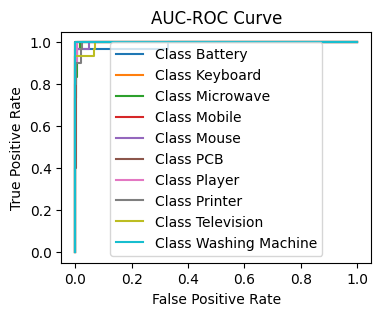

Test Accuracy: 0.9600


In [15]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

## ResNet 50

In [17]:
# Load ResNet-50 model
model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [18]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=4) 

Precision: 0.8114, Recall: 0.7900, F1-score: 0.7900
Epoch 1/4, Loss: 2.1048, Train Acc: 0.4742, Val Acc: 0.7900
Precision: 0.9333, Recall: 0.9300, F1-score: 0.9295
Epoch 2/4, Loss: 1.1228, Train Acc: 0.8462, Val Acc: 0.9300
Precision: 0.9526, Recall: 0.9500, F1-score: 0.9500
Epoch 3/4, Loss: 0.3570, Train Acc: 0.9271, Val Acc: 0.9500
Precision: 0.9608, Recall: 0.9600, F1-score: 0.9601
Epoch 4/4, Loss: 0.1600, Train Acc: 0.9708, Val Acc: 0.9600


In [19]:
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9546, Recall: 0.9533, F1-score: 0.9532
Test Accuracy: 0.9533


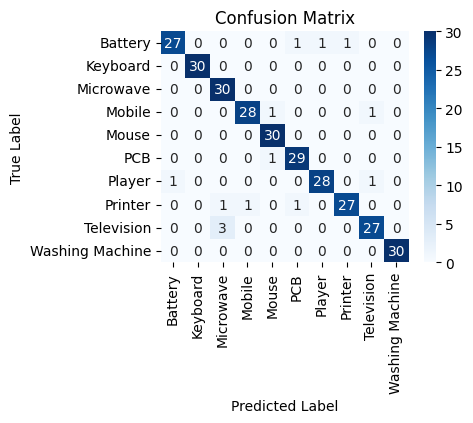

Classification Report:
                 precision    recall  f1-score   support

        Battery       0.96      0.90      0.93        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.88      1.00      0.94        30
         Mobile       0.97      0.93      0.95        30
          Mouse       0.94      1.00      0.97        30
            PCB       0.94      0.97      0.95        30
         Player       0.97      0.93      0.95        30
        Printer       0.96      0.90      0.93        30
     Television       0.93      0.90      0.92        30
Washing Machine       1.00      1.00      1.00        30

       accuracy                           0.95       300
      macro avg       0.95      0.95      0.95       300
   weighted avg       0.95      0.95      0.95       300

AUC-ROC Score: 0.9982


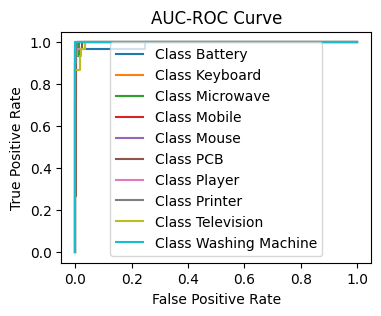

Test Accuracy: 0.9533


In [20]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

## XceptionNet

In [34]:
model = timm.create_model("xception", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)

In [35]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1) 

Precision: 0.9781, Recall: 0.9767, F1-score: 0.9767
Epoch 1/1, Loss: 0.7021, Train Acc: 0.8596, Val Acc: 0.9767


In [36]:
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9739, Recall: 0.9733, F1-score: 0.9731
Test Accuracy: 0.9733


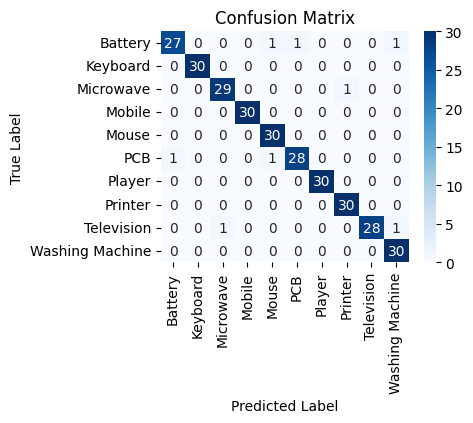

Classification Report:
                 precision    recall  f1-score   support

        Battery       0.96      0.90      0.93        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.97      0.97      0.97        30
         Mobile       1.00      1.00      1.00        30
          Mouse       0.94      1.00      0.97        30
            PCB       0.97      0.93      0.95        30
         Player       1.00      1.00      1.00        30
        Printer       0.97      1.00      0.98        30
     Television       1.00      0.93      0.97        30
Washing Machine       0.94      1.00      0.97        30

       accuracy                           0.97       300
      macro avg       0.97      0.97      0.97       300
   weighted avg       0.97      0.97      0.97       300

AUC-ROC Score: 0.9989


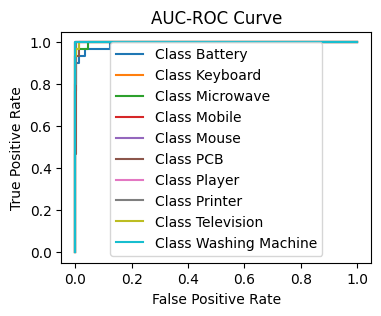

Test Accuracy: 0.9733


In [37]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

### CNN

In [9]:
# Define CNN model (Simple CNN architecture)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)  # Adjust the input size based on your image size
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
# Instantiate the CNN model
model = SimpleCNN(num_classes=num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=5e-6)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
# Function for training the model
def train_model_cnn(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


In [25]:
# Train the model
train_model_cnn(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch [1/20], Loss: 2.0152, Accuracy: 28.38%
Epoch [2/20], Loss: 1.6094, Accuracy: 45.83%
Epoch [3/20], Loss: 1.3919, Accuracy: 53.79%
Epoch [4/20], Loss: 1.2408, Accuracy: 58.50%
Epoch [5/20], Loss: 1.1207, Accuracy: 62.88%
Epoch [6/20], Loss: 1.0250, Accuracy: 66.50%
Epoch [7/20], Loss: 0.9204, Accuracy: 70.38%
Epoch [8/20], Loss: 0.8480, Accuracy: 72.71%
Epoch [9/20], Loss: 0.7695, Accuracy: 75.71%
Epoch [10/20], Loss: 0.6736, Accuracy: 78.79%
Epoch [11/20], Loss: 0.5958, Accuracy: 82.50%
Epoch [12/20], Loss: 0.5284, Accuracy: 84.67%
Epoch [13/20], Loss: 0.4631, Accuracy: 87.79%
Epoch [14/20], Loss: 0.4000, Accuracy: 89.58%
Epoch [15/20], Loss: 0.3449, Accuracy: 91.50%
Epoch [16/20], Loss: 0.2923, Accuracy: 93.62%
Epoch [17/20], Loss: 0.2606, Accuracy: 93.96%
Epoch [18/20], Loss: 0.2166, Accuracy: 96.33%
Epoch [19/20], Loss: 0.1902, Accuracy: 96.88%
Epoch [20/20], Loss: 0.1529, Accuracy: 97.71%


In [26]:
test_acc = evaluate_model(model, test_loader) 
print(f"Test Accuracy: {test_acc:.4f}")  

Precision: 0.5061, Recall: 0.5000, F1-score: 0.4934
Test Accuracy: 0.5000


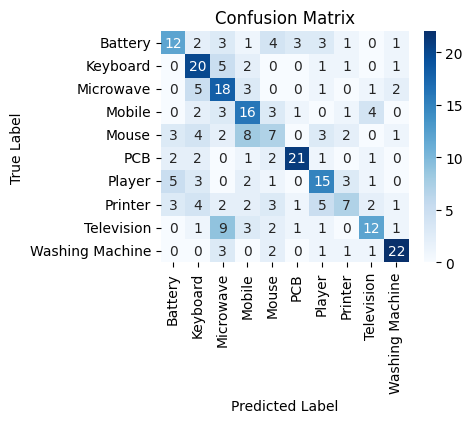

Classification Report:
                 precision    recall  f1-score   support

        Battery       0.48      0.40      0.44        30
       Keyboard       0.47      0.67      0.55        30
      Microwave       0.40      0.60      0.48        30
         Mobile       0.42      0.53      0.47        30
          Mouse       0.29      0.23      0.26        30
            PCB       0.78      0.70      0.74        30
         Player       0.48      0.50      0.49        30
        Printer       0.44      0.23      0.30        30
     Television       0.55      0.40      0.46        30
Washing Machine       0.76      0.73      0.75        30

       accuracy                           0.50       300
      macro avg       0.51      0.50      0.49       300
   weighted avg       0.51      0.50      0.49       300

AUC-ROC Score: 0.8834


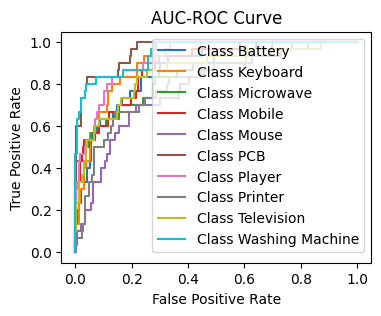

Test Accuracy: 0.5000


In [27]:
test_acc = evaluate_model_test(model, test_loader) 
print(f"Test Accuracy: {test_acc:.4f}")  

### Hybrid approach

In [46]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [58]:
# Load pretrained models
# vit_model = models.vit_b_16(pretrained=True)
vgg16_model = models.vgg16(pretrained=True)

In [59]:
import timm
xception_model = timm.create_model('xception', pretrained=True)
xception_model.fc = nn.Identity()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [60]:
# Remove classification layers to extract features
# vit_model.heads.head = nn.Identity()
vgg16_model.classifier = nn.Sequential(*list(vgg16_model.classifier.children())[:-1])
xception_model.fc = nn.Identity()

In [61]:
# Freeze model parameters
# for param in vit_model.parameters():
#     param.requires_grad = False
for param in vgg16_model.parameters():
    param.requires_grad = False
for param in xception_model.parameters():
    param.requires_grad = False

In [49]:
# Define MLP Classifier
# class HybridClassifier(nn.Module):
#     def __init__(self, vit_dim=768, vgg_dim=4096, xception_dim=2048, num_classes=10):
#         super(HybridClassifier, self).__init__()
#         self.fc1 = nn.Linear(vit_dim + vgg_dim + xception_dim, 512)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(512, num_classes)
    
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x


# classifier = HybridClassifier()

In [62]:
# Define MLP Classifier
class HybridClassifier(nn.Module):
    def __init__(self, vgg_dim=4096, xception_dim=2048, num_classes=10):
        super(HybridClassifier, self).__init__()
        self.fc1 = nn.Linear(vgg_dim + xception_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

classifier = HybridClassifier()

In [63]:
classifier 

HybridClassifier(
  (fc1): Linear(in_features=6144, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [82]:
# Define training function
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vgg16_model.to(device)
    xception_model.to(device)
    classifier.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-5, weight_decay=5e-6)
    
    for epoch in range(3):
        classifier.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            with torch.no_grad():
                vgg_features = vgg16_model(images)
                xception_features = xception_model(images)
            
            features = torch.cat((vgg_features, xception_features), dim=1)
            
            optimizer.zero_grad()
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/3], Loss: {total_loss/len(train_loader):.4f}")

In [83]:
train_model()

Epoch [1/3], Loss: 0.0105
Epoch [2/3], Loss: 0.0090
Epoch [3/3], Loss: 0.0088


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.97      0.97      0.97        30
           2       0.81      0.83      0.82        30
           3       1.00      0.97      0.98        30
           4       0.97      0.97      0.97        30
           5       0.94      1.00      0.97        30
           6       0.91      0.97      0.94        30
           7       0.91      0.97      0.94        30
           8       0.86      0.83      0.85        30
           9       0.97      0.93      0.95        30

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



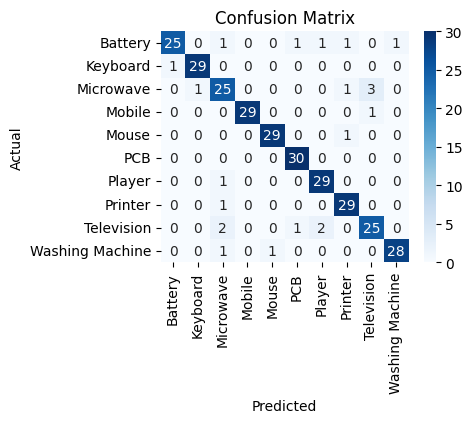

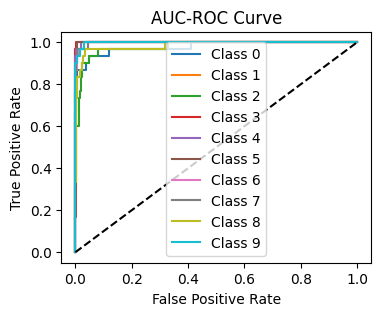

AUC-ROC Score: 0.9983
Weighted Accuracy: 0.9267
Weighted Precision: 0.9279
Weighted Recall: 0.9267
Weighted F1 Score: 0.9264


In [75]:
# Evaluate model
def evaluate_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classifier.to(device)
    classifier.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            vgg_features = vgg16_model(images)
            xception_features = xception_model(images)
            features = torch.cat((vgg_features, xception_features), dim=1)
            outputs = classifier(features)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    # AUC-ROC Curve
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    plt.figure(figsize=(4, 3))
    for i in range(10):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i}")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC-ROC Curve")
    plt.legend()
    plt.show()

    roc_score = auc(fpr, tpr)
    print(f"AUC-ROC Score: {roc_score:.4f}")
    
    
    # Weighted Metrics
    weighted_acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    print(f"Weighted Accuracy: {weighted_acc:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

evaluate_model()    #(vgg16 + xceptionet)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       1.00      0.93      0.97        30
           2       0.83      0.80      0.81        30
           3       0.97      0.93      0.95        30
           4       1.00      0.90      0.95        30
           5       0.94      0.97      0.95        30
           6       0.80      0.93      0.86        30
           7       0.93      0.93      0.93        30
           8       0.77      0.90      0.83        30
           9       0.96      0.87      0.91        30

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300



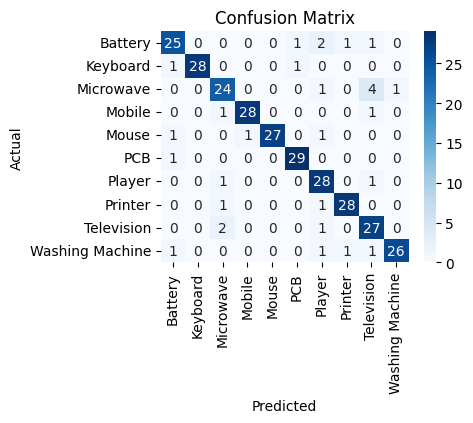

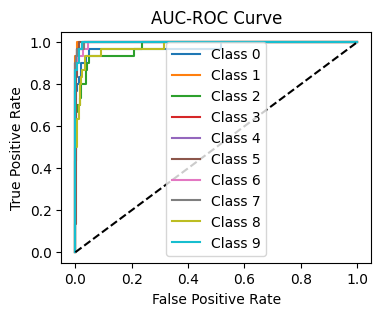

AUC-ROC Score: 0.9983
Weighted Accuracy: 0.9000
Weighted Precision: 0.9058
Weighted Recall: 0.9000
Weighted F1 Score: 0.9012


In [84]:
evaluate_model()  # (vgg16 + xceptionet)

In [51]:
# Define training function
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit_model.to(device)
    vgg16_model.to(device)
    xception_model.to(device)
    classifier.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-5)
    
    for epoch in range(5):
        classifier.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            with torch.no_grad():
                vit_features = vit_model(images)
                vgg_features = vgg16_model(images)
                xception_features = xception_model(images)
            
            features = torch.cat((vit_features, vgg_features, xception_features), dim=1)
            
            optimizer.zero_grad()
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}")

In [52]:
# Train model
train_model()

Epoch [1/10], Loss: 1.0453
Epoch [2/10], Loss: 0.2062
Epoch [3/10], Loss: 0.1196
Epoch [4/10], Loss: 0.0873
Epoch [5/10], Loss: 0.0635


In [36]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score

In [ ]:
# Load pretrained models
vit_model = models.vit_b_16(pretrained=True)
vgg16_model = models.vgg16(pretrained=True)
xception_model = models.xception(pretrained=True)

# Remove classification layers to extract features
vit_model.heads.head = nn.Identity()
vgg16_model.classifier = nn.Sequential(*list(vgg16_model.classifier.children())[:-1])
xception_model.fc = nn.Identity()

# Freeze model parameters
for param in vit_model.parameters():
    param.requires_grad = False
for param in vgg16_model.parameters():
    param.requires_grad = False
for param in xception_model.parameters():
    param.requires_grad = False

In [ ]:
# Define MLP Classifier
class HybridClassifier(nn.Module):
    def __init__(self, vit_dim=768, vgg_dim=4096, xception_dim=2048, num_classes=10):
        super(HybridClassifier, self).__init__()
        self.fc1 = nn.Linear(vit_dim + vgg_dim + xception_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

classifier = HybridClassifier()

In [ ]:
# Define training function
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit_model.to(device)
    vgg16_model.to(device)
    xception_model.to(device)
    classifier.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    
    for epoch in range(10):
        classifier.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            with torch.no_grad():
                vit_features = vit_model(images)
                vgg_features = vgg16_model(images)
                xception_features = xception_model(images)
            
            features = torch.cat((vit_features, vgg_features, xception_features), dim=1)
            
            optimizer.zero_grad()
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}")

In [ ]:
# Evaluate model
def evaluate_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classifier.to(device)
    classifier.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            vit_features = vit_model(images)
            vgg_features = vgg16_model(images)
            xception_features = xception_model(images)
            features = torch.cat((vit_features, vgg_features, xception_features), dim=1)
            outputs = classifier(features)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    # AUC-ROC Curve
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    plt.figure(figsize=(8, 6))
    for i in range(10):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i}")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC-ROC Curve")
    plt.legend()
    plt.show()
    
    # Weighted Metrics
    weighted_acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    print(f"Weighted Accuracy: {weighted_acc:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       1.00      1.00      1.00        30
           2       0.97      1.00      0.98        30
           3       0.97      1.00      0.98        30
           4       1.00      1.00      1.00        30
           5       0.97      0.93      0.95        30
           6       1.00      0.97      0.98        30
           7       1.00      1.00      1.00        30
           8       0.97      0.97      0.97        30
           9       0.97      1.00      0.98        30

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



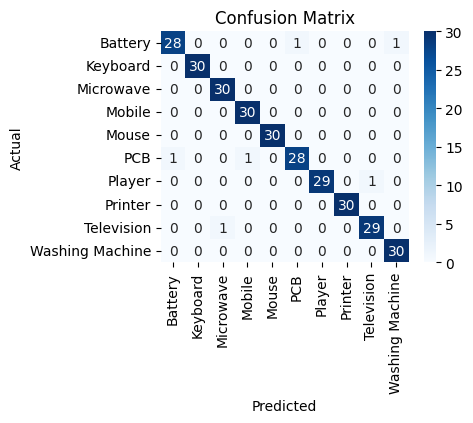

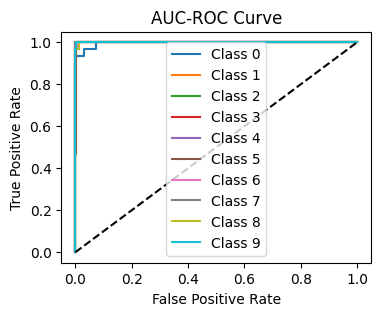

AUC-ROC Score: 0.9999
Weighted Accuracy: 0.9800
Weighted Precision: 0.9801
Weighted Recall: 0.9800
Weighted F1 Score: 0.9799


In [38]:
evaluate_model()   #(vgg16 + xceptionet + vit)